In [3]:
# Move kaggle.json to ~/.kaggle and secure permissions
!mkdir -p ~/.kaggle && mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download competition files
!kaggle competitions download -c spr-x-ray-age -p /content

# Unzip
!unzip -q /content/spr-x-ray-age.zip -d /content/spr-x-ray-age-raw



mv: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 4, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.11/dist-packages/kaggle/__init__.py", line 6, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.11/dist-packages/kaggle/api/kaggle_api_extended.py", line 434, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method. See setup instructions at https://github.com/Kaggle/kaggle-api/
unzip:  cannot find or open /content/spr-x-ray-age.zip, /content/spr-x-ray-age.zip.zip or /content/spr-x-ray-age.zip.ZIP.


In [4]:
#!pip install -q tensorflow


In [5]:
# 1) Imports and Environment Configuration
# =====================================================
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import (
    GlobalAveragePooling2D, BatchNormalization, Dropout, Dense
)
from tensorflow.keras.models import Model

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

2025-07-10 01:30:43.965842: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752111044.173601      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752111044.236956      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [6]:
# ==========================================
# 2) Dataset Paths and CSV Preparation
# ==========================================
CSV_PATH = '/kaggle/input/spr-x-ray-age/train_age.csv'
IMG_DIR = '/kaggle/input/spr-x-ray-age/kaggle/kaggle/train'
df = pd.read_csv('/kaggle/input/spr-x-ray-age/train_age.csv')

# Create a filename column padded to 6 digits, e.g. 23 -> "000023.png"
df['filename'] = df['imageId'].apply(lambda x: f"{int(x):06d}.png")



In [7]:
# =====================================================
# 3) Train / Validation Split
# =====================================================
train_df, valid_df = train_test_split(df, test_size=0.15, random_state=SEED)


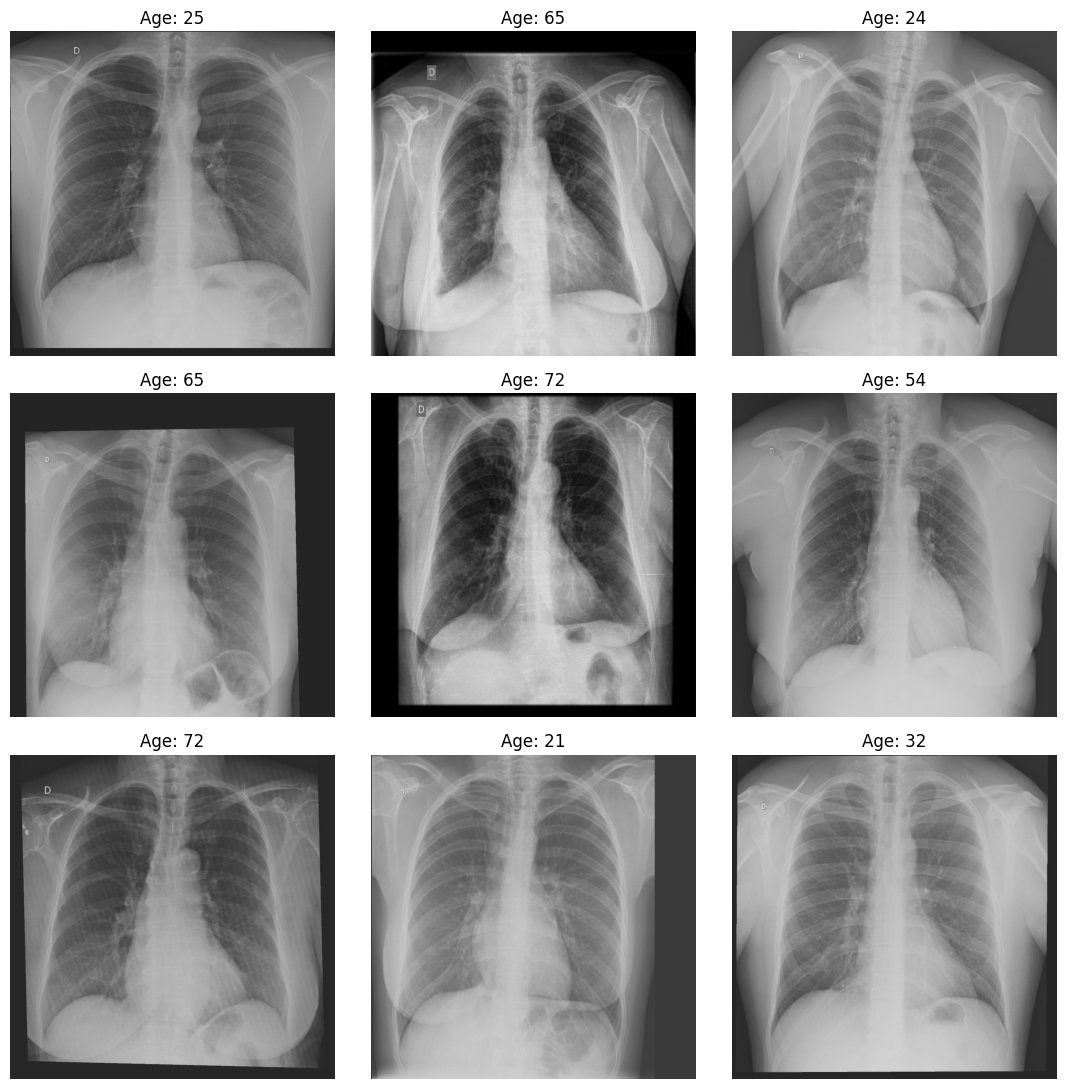

In [8]:
# =====================================================
# 4) Show 9 Sample Images
# =====================================================
sample_df = train_df.sample(9, random_state=SEED).reset_index(drop=True)
plt.figure(figsize=(11, 11))
for i in range(9):
    img_path = os.path.join(IMG_DIR, sample_df['filename'][i])
    img = plt.imread(img_path)
    plt.subplot(3, 3, i+1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Age: {int(sample_df['age'][i])}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [9]:
# =====================================================
# 5) ImageDataGenerators
# =====================================================
IMG_SIZE   = (224, 224)
BATCH_SIZE = 32

train_gen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.10,
)

valid_gen = ImageDataGenerator(rescale=1.0 / 255)

train_it = train_gen.flow_from_dataframe(
    dataframe=train_df,
    directory=IMG_DIR,
    x_col='filename',
    y_col='age',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='raw',
    shuffle=True,
    seed=SEED,
)

valid_it = valid_gen.flow_from_dataframe(
    dataframe=valid_df,
    directory=IMG_DIR,
    x_col='filename',
    y_col='age',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='raw',
    shuffle=False,
)

Found 9096 validated image filenames.
Found 1606 validated image filenames.


In [10]:
# =====================================================
# 6) Build MobileNetV2 Model
# =====================================================
base_model = MobileNetV2(
    include_top=False,
    input_shape=IMG_SIZE + (3,),
    weights='imagenet',
)
base_model.trainable = False  # feature extraction only

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.25)(x)
x = Dense(128, activation='swish')(x)
x = Dropout(0.10)(x)
output = Dense(1)(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='mae',
    metrics=['mae'],
)
model.summary()


I0000 00:00:1752111072.952875      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,427,201 (9.26 MB)

 Trainable params: 166,657 (651.00 KB)

 Non-trainable params: 2,260,544 (8.62 MB)

In [11]:
# =====================================================
# 7) Callbacks
# =====================================================
callbacks = [
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, verbose=1),
    ModelCheckpoint(
        filepath='best_mobilenetv2.h5',
        monitor='val_loss',
        save_best_only=True,
        verbose=1,
    ),
]

In [12]:
# 8) Initial Training (Feature Extraction)
# =====================================================
history = model.fit(
    train_it,
    epochs=30,
    validation_data=valid_it,
    callbacks=callbacks,
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30


I0000 00:00:1752111088.484721     110 service.cc:148] XLA service 0x788634112f70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1752111088.485637     110 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1752111089.450618     110 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/285 ━━━━━━━━━━━━━━━━━━━━ 1:11:29 15s/step - loss: 49.5066 - mae: 49.5066

I0000 00:00:1752111094.093556     110 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 27.7876 - mae: 27.7876
Epoch 1: val_loss improved from inf to 11.94018, saving model to best_mobilenetv2.h5
285/285 ━━━━━━━━━━━━━━━━━━━━ 448s 2s/step - loss: 27.7531 - mae: 27.7531 - val_loss: 11.9402 - val_mae: 11.9402 - learning_rate: 0.0010
Epoch 2/30
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 11.4363 - mae: 11.4363
Epoch 2: val_loss improved from 11.94018 to 9.51143, saving model to best_mobilenetv2.h5
285/285 ━━━━━━━━━━━━━━━━━━━━ 350s 1s/step - loss: 11.4354 - mae: 11.4354 - val_loss: 9.5114 - val_mae: 9.5114 - learning_rate: 0.0010
Epoch 3/30
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 10.6537 - mae: 10.6537
Epoch 3: val_loss improved from 9.51143 to 9.25872, saving model to best_mobilenetv2.h5
285/285 ━━━━━━━━━━━━━━━━━━━━ 349s 1s/step - loss: 10.6538 - mae: 10.6538 - val_loss: 9.2587 - val_mae: 9.2587 - learning_rate: 0.0010
Epoch 4/30
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 10.3737 - mae: 10.3737
Epoch 4: val_loss

In [13]:
# 9) Fine‑Tune Top 20 Layers of Base Model
# =====================================================
for layer in base_model.layers[-20:]:
    layer.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='mae',
    metrics=['mae'],
)

fine_tune_history = model.fit(
    train_it,
    epochs=15,
    validation_data=valid_it,
    callbacks=callbacks,
)

Epoch 1/15


E0000 00:00:1752121509.227137     112 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1752121509.424554     112 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 11.1587 - mae: 11.1587
Epoch 1: val_loss did not improve from 8.35596
285/285 ━━━━━━━━━━━━━━━━━━━━ 380s 1s/step - loss: 11.1564 - mae: 11.1564 - val_loss: 12.3504 - val_mae: 12.3504 - learning_rate: 1.0000e-04
Epoch 2/15
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 9.5116 - mae: 9.5116
Epoch 2: val_loss did not improve from 8.35596
285/285 ━━━━━━━━━━━━━━━━━━━━ 350s 1s/step - loss: 9.5108 - mae: 9.5108 - val_loss: 27.7547 - val_mae: 27.7547 - learning_rate: 1.0000e-04
Epoch 3/15
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 8.9167 - mae: 8.9167
Epoch 3: val_loss did not improve from 8.35596
285/285 ━━━━━━━━━━━━━━━━━━━━ 350s 1s/step - loss: 8.9164 - mae: 8.9164 - val_loss: 23.2732 - val_mae: 23.2732 - learning_rate: 1.0000e-04
Epoch 4/15
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 8.5436 - mae: 8.5436
Epoch 4: ReduceLROnPlateau reducing learning rate to 2.9999999242136255e-05.

Epoch 4: val_loss did not improve from 8.35596
285/285

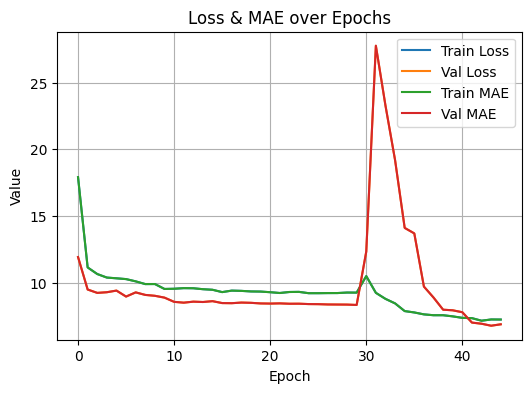

In [14]:
# =====================================================
# 10) Plot Training Curves
# =====================================================
plt.figure(figsize=(6,4))
plt.plot(history.history['loss'] + fine_tune_history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'] + fine_tune_history.history['val_loss'], label='Val Loss')
plt.plot(history.history['mae'] + fine_tune_history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'] + fine_tune_history.history['val_mae'], label='Val MAE')
plt.title("Loss & MAE over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.grid()
plt.legend()
plt.show()

In [15]:
# =====================================================
# 11) Save Final Model
# =====================================================
model.save('spr_xray_age_mobilenetv2_final.h5')
print("✅ Model saved: spr_xray_age_mobilenetv2_final.h5")

✅ Model saved: spr_xray_age_mobilenetv2_final.h5
